# TensorFlow: Optimization & Training (Expert)

https://www.tensorflow.org/  
공식 홈페이지에서 설명하는 Expert 버젼을 배워보자

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

### Note for GPU version

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## 학습 과정 돌아보기

![logic](image/logic.png)

# Build Model

![model](image/model.png)

In [2]:
input_shape = (28, 28, 1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype=tf.float64)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Preprocess

텐서플로우 공식홈페이지에서 말한 expert한 방법
- tf.data 사용

In [4]:
mnist = datasets.mnist

# Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add Channel
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

- from_tensor_slices()
- shuffle()
- batch()

## tf.data

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# No need to shuffle
test_ds = test_ds.batch(32)

### Visualize Data

matplotlib 불러와서 데이터 시각화하기

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
image, label = next(iter(train_ds))

In [13]:
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

In [14]:
type(label)

tensorflow.python.framework.ops.EagerTensor

train_ds.take()

(32, 28, 28, 1)

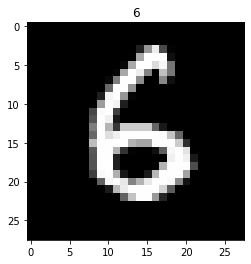

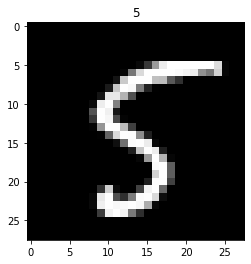

In [15]:
for image, label in train_ds.take(2):
    plt.title(label[0].numpy())
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

# Training (Keras)

Keras로 학습 할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs=100)

# Optimization  

- Loss Function
- Optimizer

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

- Loss Function를 담을 곳
- Metrics

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Training  

@tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [8]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [9]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [10]:
for epoch in range(10):
    for images, labels in train_ds:
        train_step(images, labels)
        
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    
    print(template.format(epoch + 1, 
                          train_loss.result(), 
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.09877197444438934, Accuracy: 96.9000015258789, Test Loss: 0.0545661598443985, Test Accuracy: 98.19999694824219
Epoch 2, Loss: 0.06679122149944305, Accuracy: 97.90250396728516, Test Loss: 0.043320249766111374, Test Accuracy: 98.6050033569336
Epoch 3, Loss: 0.052236538380384445, Accuracy: 98.3566665649414, Test Loss: 0.040348686277866364, Test Accuracy: 98.73999786376953
Epoch 4, Loss: 0.043626829981803894, Accuracy: 98.62958526611328, Test Loss: 0.038761310279369354, Test Accuracy: 98.79999542236328
Epoch 5, Loss: 0.03765902668237686, Accuracy: 98.82233428955078, Test Loss: 0.03921177610754967, Test Accuracy: 98.79800415039062
Epoch 6, Loss: 0.033364564180374146, Accuracy: 98.95639038085938, Test Loss: 0.038316573947668076, Test Accuracy: 98.83000183105469
Epoch 7, Loss: 0.030227649956941605, Accuracy: 99.05357360839844, Test Loss: 0.036432359367609024, Test Accuracy: 98.9000015258789
Epoch 8, Loss: 0.027424251660704613, Accuracy: 99.13957977294922, Test Loss: 0.0354028